In [1]:
import json
import web3
web3.eth.handleRevert = True

from solc import compile_standard
from web3 import Web3
from eth_tester import PyEVMBackend, EthereumTester

from matplotlib import pyplot as plt

import seaborn as sns

In [30]:
with open('../notebooks/Median2.sol') as f:
    compiled_sol = compile_standard({
        "language": "Solidity",
        "sources": {
            "Median2.sol": {
                "content": f.read()
            }
        },
        "settings": {
            "outputSelection": {
                "*": {
                    "*": [
                        "metadata", "evm.bytecode",
                        "evm.bytecode.sourceMap"
                    ]
                }
            }
        }
    })

In [32]:
# web3.py instance
w3 = Web3(Web3.EthereumTesterProvider(EthereumTester(PyEVMBackend())))
# set pre-funded account as sender
w3.eth.default_account = w3.eth.accounts[8]
w3.eth.getBalance(w3.eth.default_account)

1000000000000000000000000

In [33]:
# get bytecode
bytecode = compiled_sol['contracts']['Median2.sol']['Median2']['evm']['bytecode']['object']
# get abi
abi = json.loads(compiled_sol['contracts']['Median2.sol']['Median2']['metadata'])['output']['abi']

Median = w3.eth.contract(abi=abi, bytecode=bytecode)

# Submit the transaction that deploys the contract
tx_hash = Median.constructor().transact()
# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = w3.eth.getTransactionReceipt(tx_hash)

median = w3.eth.contract(
    address=tx_receipt.contractAddress,
    abi=abi
)

# TEST gas estimate

In [5]:
import itertools
import random
import pandas as pd

df = pd.DataFrame({
    'length': pd.Series([], dtype='int'), 
    'gas_cost': pd.Series([], dtype='int'), 
    'type': pd.Series([], dtype='str'), 
    'nrun': pd.Series([], dtype='int'), 
})

def _insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

def factorial(n):
    res = 1
    for x in range(1, n + 1):
        res *= x
    return res

for n in range(1, 31):
    arr = list(range(1, n + 1))
    for r in range(100):
        random.shuffle(arr)
        gas_cost1 = median.functions.compute(arr[:]).estimateGas()
        gas_cost2 = median.functions.compute2(arr[:]).estimateGas()
        gas_cost3 = median.functions.compute3(arr[:]).estimateGas()
        row2 = [n, gas_cost2, 'insertion-sort', r]
        row1 = [n, gas_cost1, 'quickselect', r]
        row3 = [n, gas_cost3, 'quickselect_with-median-heuristic', r]
        _insert(df, row1)
        _insert(df, row2)
        _insert(df, row3)
        if n <= 7:
            gas_cost4 = median.functions.compute4(arr[:]).estimateGas()
            row4 = [n, gas_cost4, 'direct-comparison', r]
            _insert(df, row4)
            
    print(n)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [8]:
df

,length,gas_cost,type,nrun
0,1,33661,quickselect,0
1,1,33661,insertion-sort,0
2,1,33661,quickselect_with-median-heuristic,0
3,1,33661,direct-comparison,0
4,1,33661,quickselect,1
...,...,...,...,...
9695,30,244453,insertion-sort,98
9696,30,134998,quickselect_with-median-heuristic,98
9697,30,86351,quickselect,99
9698,30,280937,insertion-sort,99


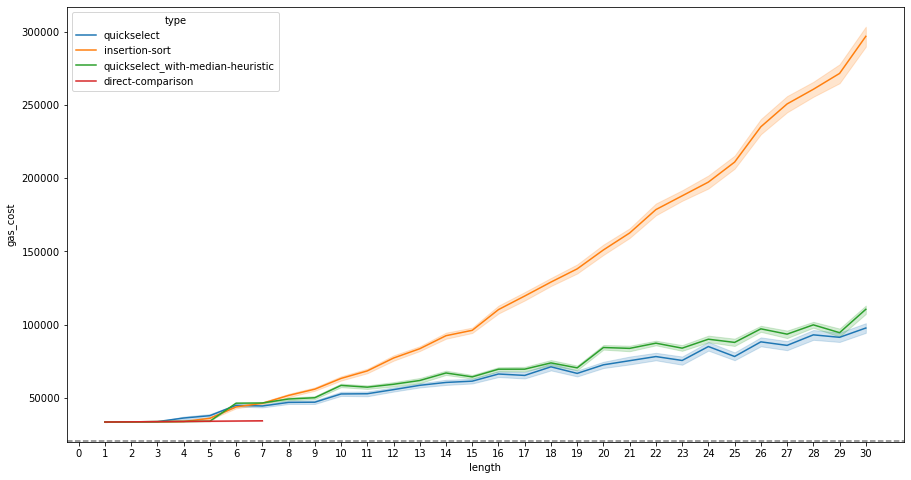

In [10]:
#g = df.groupby('length').mean()
plt.figure(figsize=(15,8))

g = sns.lineplot(data=df, x="length", y="gas_cost", hue="type");

plt.axhline(21_000, ls='--', color='grey')

g.set_xticks(list(range(31)));

#plt.ylim(0, 100_000);

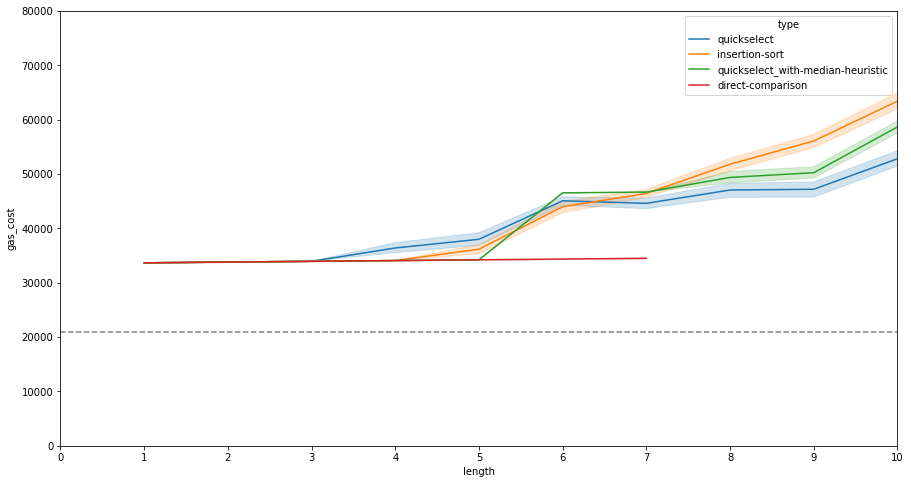

In [14]:
plt.figure(figsize=(15,8))

g = sns.lineplot(data=df, x="length", y="gas_cost", hue="type");

plt.axhline(21_000, ls='--', color='grey')

g.set_xticks(list(range(31)));

plt.xlim(0, 10);
plt.ylim(0, 80_000);